# Autotalker Tutorial

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 07.12.2022
- **Date of Last Modification:** 13.12.2022

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import argparse
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Configure Paths and Create Directories

In [4]:
# Define paths
figure_path = "../figures"
model_artefacts_path = "../model_artefacts"

gp_data_folder_path = "../datasets/gp_data/" # gene program data
srt_data_folder_path = "../datasets/srt_data/" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "omnipath_lr_interactions.csv"

# Create required directories
os.makedirs("mlruns", exist_ok=True)
os.makedirs(gp_data_folder_path, exist_ok=True)

### 1.3 Run Notebook Setup

In [5]:
# Define default matplotlib figure size
matplotlib.rcParams["figure.figsize"] = (5, 5)

In [6]:
# Ignore future warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [7]:
# Get time of notebook execution for timestamping saved artefacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [8]:
# Set random seed
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

### 1.4 Define Parameters

**Note:** ´edge_batch_size´ is a very important hyperparameter. Training does not work when it is too small because the gradients will be too noisy. If it is too high, you might run into GPU memory constraints.

In [12]:
## Dataset
dataset = "squidpy_seqfish_mouse_organogenesis"
#dataset = "squidpy_slideseqv2_mouse_hippocampus"
#dataset = "vizgen_merfish_mouse_brain"
#dataset = "vizgen_merfish_mouse_liver" 
#dataset = "vizgen_merfish_human_liver_cancer"
#dataset = "10x_xenium_human_breast_cancer"
#dataset = "starmap_plus_mouse_cns"
#dataset = "eel_fish_mouse_brain"
n_neighs = 8 # for spatial neighborhood graph; constrained by GPU memory

## Model
# adata Keys
counts_key = "counts"
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"

# Neighborhood Gene Expression Aggregation (Node Label Method)
#node_label_method = "self" # does only apply for fully-connected GPs
#node_label_method = "one-hop-sum"
node_label_method = "one-hop-norm"
#node_label_method = "one-hop-attention"

# Architecture
active_gp_thresh_ratio = 0
dropout_rate_encoder = 0.
dropout_rate_graph_decoder = 0.

# Trainer
n_epochs = 3
n_epochs_all_gps = 0
n_epochs_no_edge_recon = 0
lr = 0.01
weight_decay = 0.
lambda_edge_recon = None
lambda_gene_expr_recon = 1.
lambda_group_lasso = 0.
lambda_l1_addon = 0.
edge_val_ratio = 0.1
edge_test_ratio = 0.05
node_val_ratio = 0.1
edge_batch_size = 64
node_batch_size = 64

## 2. Data

### 2.1 Load Data & Compute Spatial Neighbor Graph

In [13]:
adata = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}.h5ad")

# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key=spatial_key, n_neighs=n_neighs)

### 2.2 Explore Data

Using dataset squidpy_seqfish_mouse_organogenesis.
Number of nodes (cells): 19416
Number of node features (genes): 351
Average number of edges per node: 8.0
Number of total edges: 78058
--------------------


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


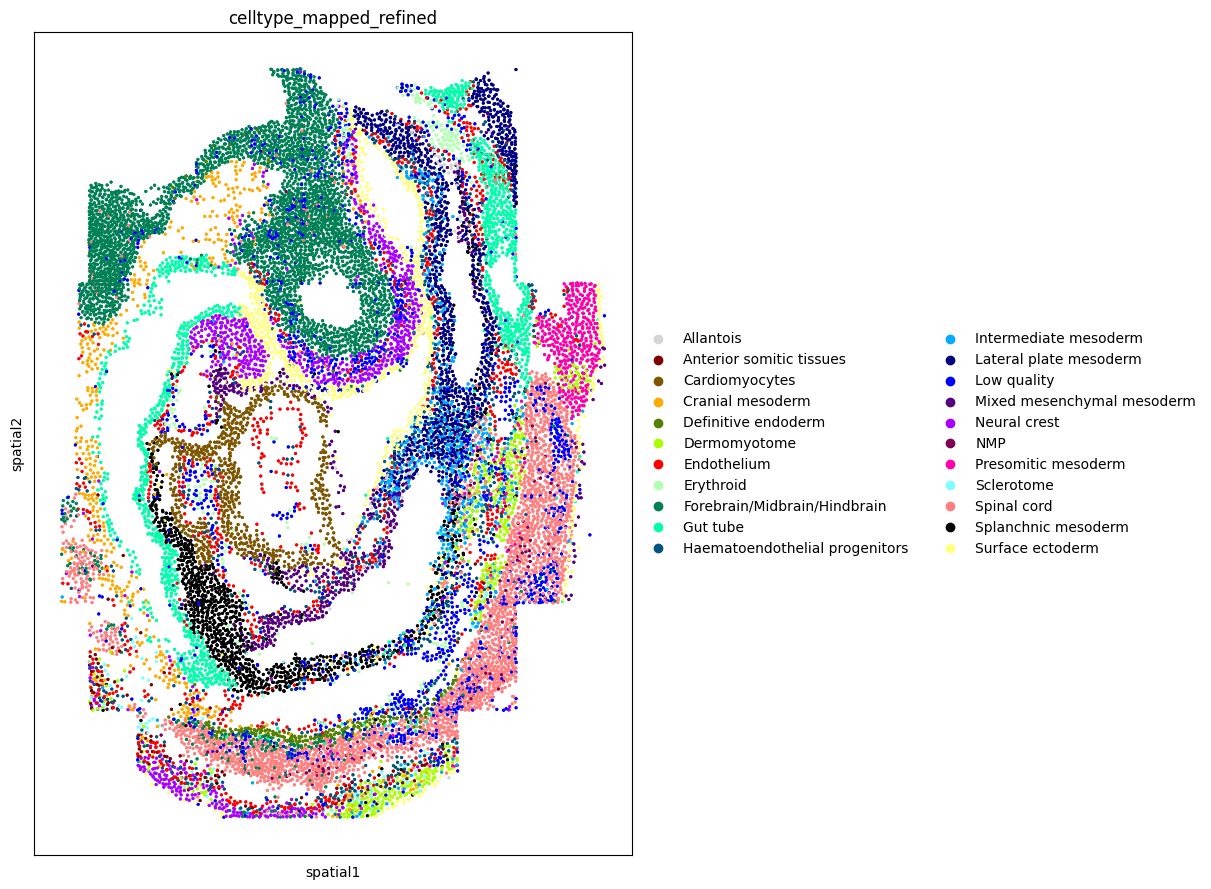

In [14]:
print(f"Using dataset {dataset}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")
avg_edges_per_node = round(adata.obsp['spatial_connectivities'].sum(axis=0).mean(), 2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(sp.triu(adata.obsp['spatial_connectivities'], k=1).sum())
print(f"Number of total edges: {n_edges}", sep="")
print("--------------------")

# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

## 3. Train Autotalker Model with Cell-Cell-Interaction (CCI) Gene Programs

### 3.1 Create Prior Knowledge CCI Gene Program Mask

In [10]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=True,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [11]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [12]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path: str="../datasets/gp_data/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [13]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [14]:
# Filter and combine combined gene interaction gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode=None, #"subset",
    combine_overlap_gps=False, #True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 1725.
Number of gene programs after filtering and combining: 1725.


In [15]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns[gp_names_key])

In [16]:
# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_gp_sources'].sum()}.")

Number of gene programs with probed genes: 802.
Example gene programs: ['CDHR2_ligand_targetgenes_GP', 'IL1A_ligand_targetgenes_GP', 'CCL14_ligand_targetgenes_GP', 'CER1_ligand_receptor_GP', 'PTHLH_ligand_targetgenes_GP'].
Number of gene program target genes: 68295.
Number of gene program source genes: 135.


#### 4.4.2 Initialize, Train & Save Model

In [17]:
model = Autotalker(adata,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.1
GCN ENCODER -> n_input: 351, n_hidden: 802, n_latent: 802, n_addon_latent: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 802, n_addon_input: 0, n_output: 702


In [18]:
mlflow.end_run()
experiment = mlflow.set_experiment("autotalker_combined_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            n_epochs_no_edge_recon=n_epochs_no_edge_recon,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            weight_decay=weight_decay,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_group_lasso=lambda_group_lasso,
            lambda_l1_addon=lambda_l1_addon,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of test nodes: 0
Number of training edges: 66351
Number of validation edges: 7805
Number of test edges: 3902

--- MODEL TRAINING ---
Epoch 1/3 |██████--------------| 33.3% val_auroc_score: 0.9444; val_auprc_score: 0.9060; val_best_acc_score: 0.8018; val_best_f1_score: 0.8345; train_kl_reg_loss: 0.2153; train_edge_recon_loss: 2.6651; train_gene_expr_recon_loss: 471.4049; train_group_lasso_reg_loss: 8.0997; train_global_loss: 482.3849; train_optim_loss: 482.3849; val_kl_reg_loss: 0.2352; val_edge_recon_loss: 1.4439; val_gene_expr_recon_loss: 463.1498; val_group_lasso_reg_loss: 6.7216; val_global_loss: 471.5505; val_optim_loss: 471.5505
Epoch 2/3 |█████████████-------| 66.7% val_auroc_score: 0.9427; val_auprc_score: 0.9011; val_best_acc_score: 0.7944; val_best_f1_score: 0.8294; train_kl_reg_loss: 0.1674; train_edge_recon_loss: 1.5584; train_gene_expr_recon_loss: 464.1256; train_group_lasso

In [19]:
# Check number of active gene programs
model.adata.obsm["autotalker_latent"].shape

(19416, 26)

In [20]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_combined_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

## 4. Learn New CCI Gene Programs

In [29]:
model = Autotalker.load(dir_path=f"./model_artefacts/{dataset}/autotalker_combined_gps_{current_timestamp}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        n_addon_gps=10,
                        gp_names_key=gp_names_key,
                        freeze_non_addon_weights=True)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.1
GCN ENCODER -> n_input: 351, n_hidden: 802, n_latent: 802, n_addon_latent: 10, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 802, n_addon_input: 10, n_output: 702


In [30]:
mlflow.end_run()
experiment = mlflow.set_experiment("autotalker_combined_denovo_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            n_epochs_no_edge_recon=n_epochs_no_edge_recon,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            weight_decay=weight_decay,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_group_lasso=lambda_group_lasso,
            lambda_l1_addon=lambda_l1_addon,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of test nodes: 0
Number of training edges: 66351
Number of validation edges: 7805
Number of test edges: 3902

--- MODEL TRAINING ---
Epoch 1/3 |██████--------------| 33.3% val_auroc_score: 0.9444; val_auprc_score: 0.9060; val_best_acc_score: 0.8018; val_best_f1_score: 0.8345; train_kl_reg_loss: 0.2380; train_edge_recon_loss: 1.7346; train_gene_expr_recon_loss: 464.5471; train_group_lasso_reg_loss: 6.8264; train_addon_gp_l1_reg_loss: 21.6620; train_global_loss: 495.0081; train_optim_loss: 495.0081; val_kl_reg_loss: 0.2378; val_edge_recon_loss: 1.4439; val_gene_expr_recon_loss: 463.1152; val_group_lasso_reg_loss: 6.7574; val_addon_gp_l1_reg_loss: 7.6661; val_global_loss: 479.2203; val_optim_loss: 479.2203
Epoch 2/3 |█████████████-------| 66.7% val_auroc_score: 0.9377; val_auprc_score: 0.8953; val_best_acc_score: 0.8004; val_best_f1_score: 0.8336; train_kl_reg_loss: 0.3415; train_edge_reco

In [32]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_combined_denovo_gps_{current_timestamp}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

## 6. Analysis

In [40]:
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 812.
Number of active gene programs: 26.


In [41]:
active_gps

array(['CTF1_ligand_targetgenes_GP', 'IL12A_ligand_targetgenes_GP',
       'IL21_ligand_targetgenes_GP', 'TSLP_ligand_targetgenes_GP',
       'GH2_ligand_targetgenes_GP', 'IL10_ligand_targetgenes_GP',
       'IFNL1_ligand_targetgenes_GP', 'CDH2_ligand_targetgenes_GP',
       'CSH1_ligand_targetgenes_GP', 'CSHL1_ligand_targetgenes_GP',
       'COL4A1_ligand_targetgenes_GP', 'DKK2_ligand_targetgenes_GP',
       'DLL1_ligand_targetgenes_GP', 'GDF2_ligand_targetgenes_GP',
       'LEFTY2_ligand_targetgenes_GP', 'MMP13_ligand_targetgenes_GP',
       'PTGS2_ligand_targetgenes_GP', 'GPNMB_ligand_targetgenes_GP',
       'CRLF2_ligand_targetgenes_GP', 'VGF_ligand_targetgenes_GP',
       'IL27_ligand_targetgenes_GP', 'LEFTY1_ligand_targetgenes_GP',
       'SFRP2_ligand_targetgenes_GP', 'SECTM1_ligand_targetgenes_GP',
       'GDF3_ligand_targetgenes_GP', 'CDH18_ligand_targetgenes_GP'],
      dtype=object)

In [52]:
# Use autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata, min_dist=0.3)

### 6.1 Cell-type Annotations in Physical and Latent Space

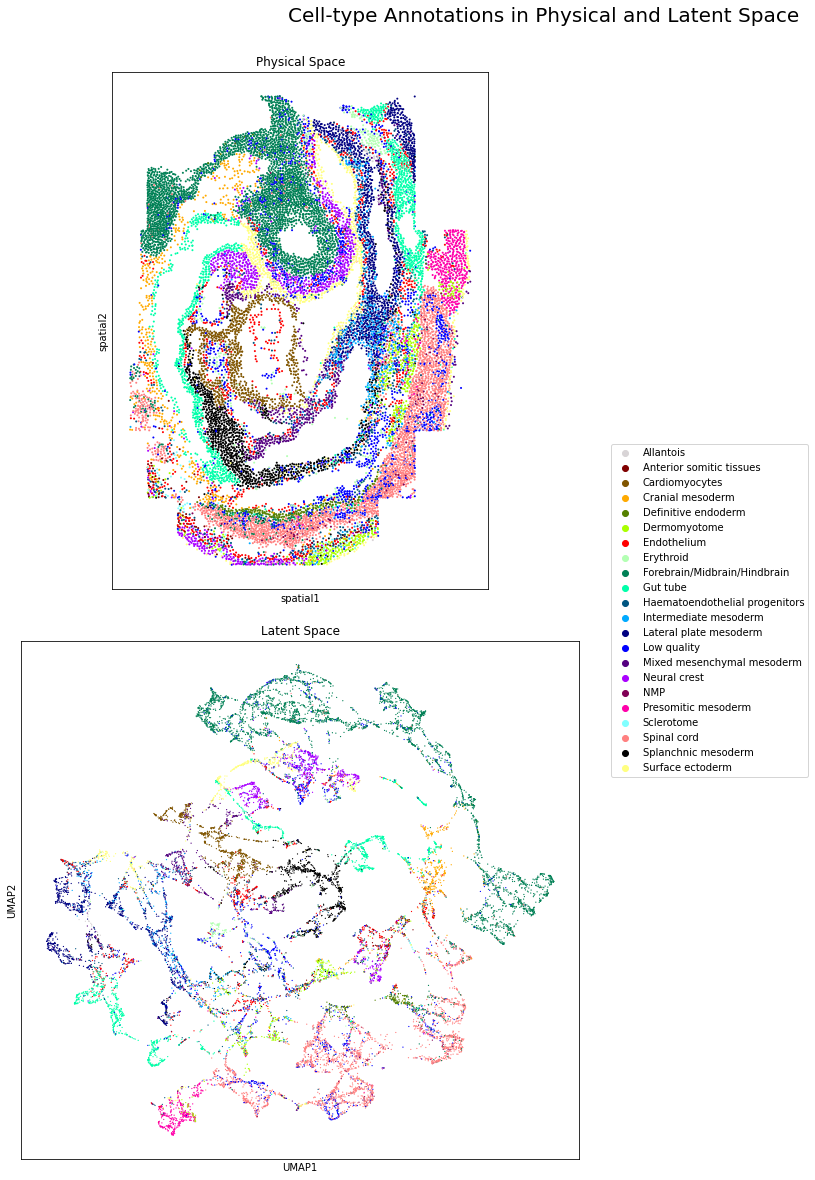

In [53]:
# Create subplot of cell-type annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
title = fig.suptitle(t="Cell-type Annotations in Physical and Latent Space",
                     x=0.85,
                     y=0.925,
                     fontsize=20)
sc.pl.spatial(adata=model.adata,
              color=[cell_type_key],
              spot_size=0.03,
              title="Physical Space",
              ax=axs[0],
              show=False)
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           title="Latent Space",
           ax=axs[1],
           show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.225, 0.625))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig(f"figures/analysis/{dataset}/cell_type_annotations_in_physical_and_latent_space_{current_timestamp}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 6.2 Latent Leiden Cluster Annotations in Latent and Physical Space

In [54]:
model.compute_latent_graph_connectivities(adata=model.adata,
                                          n_neighbors=8,
                                          mode="knn",
                                          seed=random_seed)

In [55]:
# Compute latent Leiden clustering
resolution = 0.3

sc.tl.leiden(adata=model.adata,
             resolution=resolution,
             random_state=random_seed,
             key_added=f"latent_leiden_{str(resolution)}",
             adjacency=model.adata.obsp["latent_connectivities"])

# Compute UMAP for latent Leiden clusters
sc.pp.neighbors(adata=model.adata, use_rep=latent_key)
sc.tl.umap(adata=model.adata, min_dist=0.3)

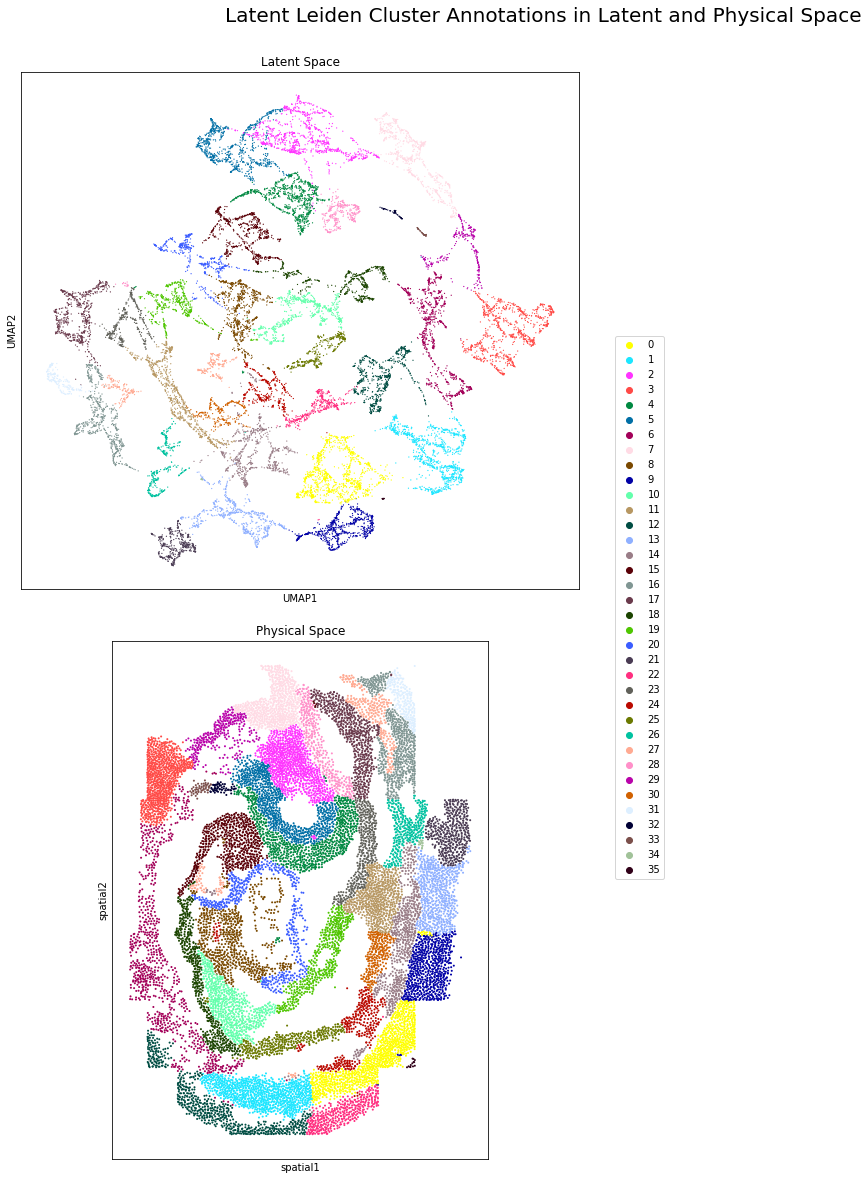

In [56]:
# Create subplot of latent Leiden cluster annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
title = fig.suptitle(t="Latent Leiden Cluster Annotations in Latent and Physical Space",
                     x=0.85,
                     y=0.925,
                     fontsize=20)
sc.pl.umap(adata=model.adata,
           color=[f"latent_leiden_{str(resolution)}"],
           color_map="magma",
           title=f"Latent Space",
           ax=axs[0],
           show=False)
sc.pl.spatial(adata=model.adata,
              color=[f"latent_leiden_{str(resolution)}"],
              color_map="magma",
              spot_size=0.03,
              title=f"Physical Space",
              ax=axs[1],
              show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.025, 0.7))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig(f"figures/analysis/{dataset}/latent_leiden_cluster_annotations_in_latent_and_physical_space_{current_timestamp}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 6.3 Gene Program Enrichments

#### 6.3.1 Cell-type Gene Program Enrichments

In [57]:
differential_gp_scores_key = "autotalker_cell_type_differential_gp_scores"
n_top_up_gps = 6
n_top_down_gps = 6

##### 6.3.1.1 Explore All GPs Across All Categories

In [58]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=None,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [59]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

category                 gene_program      p_h0      p_h1  \
0       Cardiomyocytes   DLL1_ligand_targetgenes_GP  0.834039  0.165961   
1            Erythroid  CSHL1_ligand_targetgenes_GP  0.764225  0.235775   
2  Presomitic mesoderm   CDH2_ligand_targetgenes_GP  0.761248  0.238752   
3  Presomitic mesoderm    VGF_ligand_targetgenes_GP  0.757927  0.242073   
4  Definitive endoderm   IL21_ligand_targetgenes_GP  0.743767  0.256233   
5            Erythroid   DLL1_ligand_targetgenes_GP  0.736376  0.263624   

   log_bayes_factor  
0          1.614529  
1          1.175984  
2          1.159536  
3          1.141348  
4          1.065641  
5          1.027218

In [61]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

category                  gene_program      p_h0      p_h1  \
571            Erythroid     VGF_ligand_targetgenes_GP  0.226060  0.773940   
570       Cardiomyocytes  LEFTY2_ligand_targetgenes_GP  0.241753  0.758247   
569  Presomitic mesoderm  LEFTY2_ligand_targetgenes_GP  0.245766  0.754234   
568       Cardiomyocytes   IL12A_ligand_targetgenes_GP  0.265314  0.734686   
567  Presomitic mesoderm   IL12A_ligand_targetgenes_GP  0.304970  0.695030   
566  Definitive endoderm   MMP13_ligand_targetgenes_GP  0.324630  0.675370   

     log_bayes_factor  
571         -1.230695  
570         -1.143095  
569         -1.121323  
568         -1.018528  
567         -0.823744  
566         -0.732575

         Falling back to preprocessing with `sc.pp.pca` and default params.


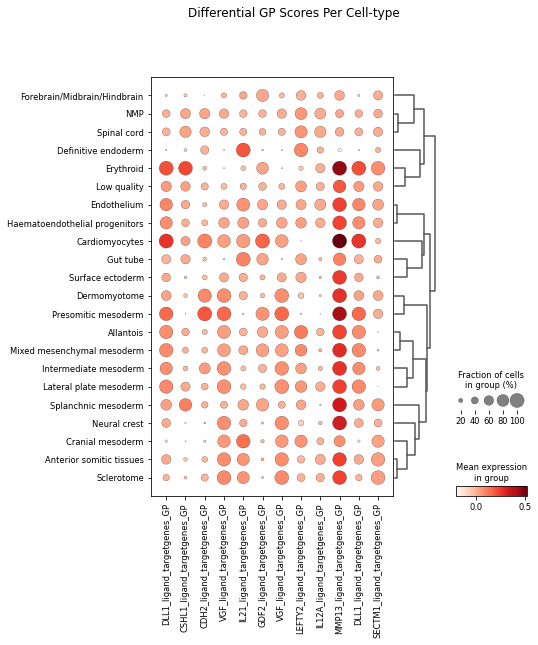

In [63]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/differential_gp_scores_per_cell_type_all_categories_{current_timestamp}.png")
plt.show()

In [64]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

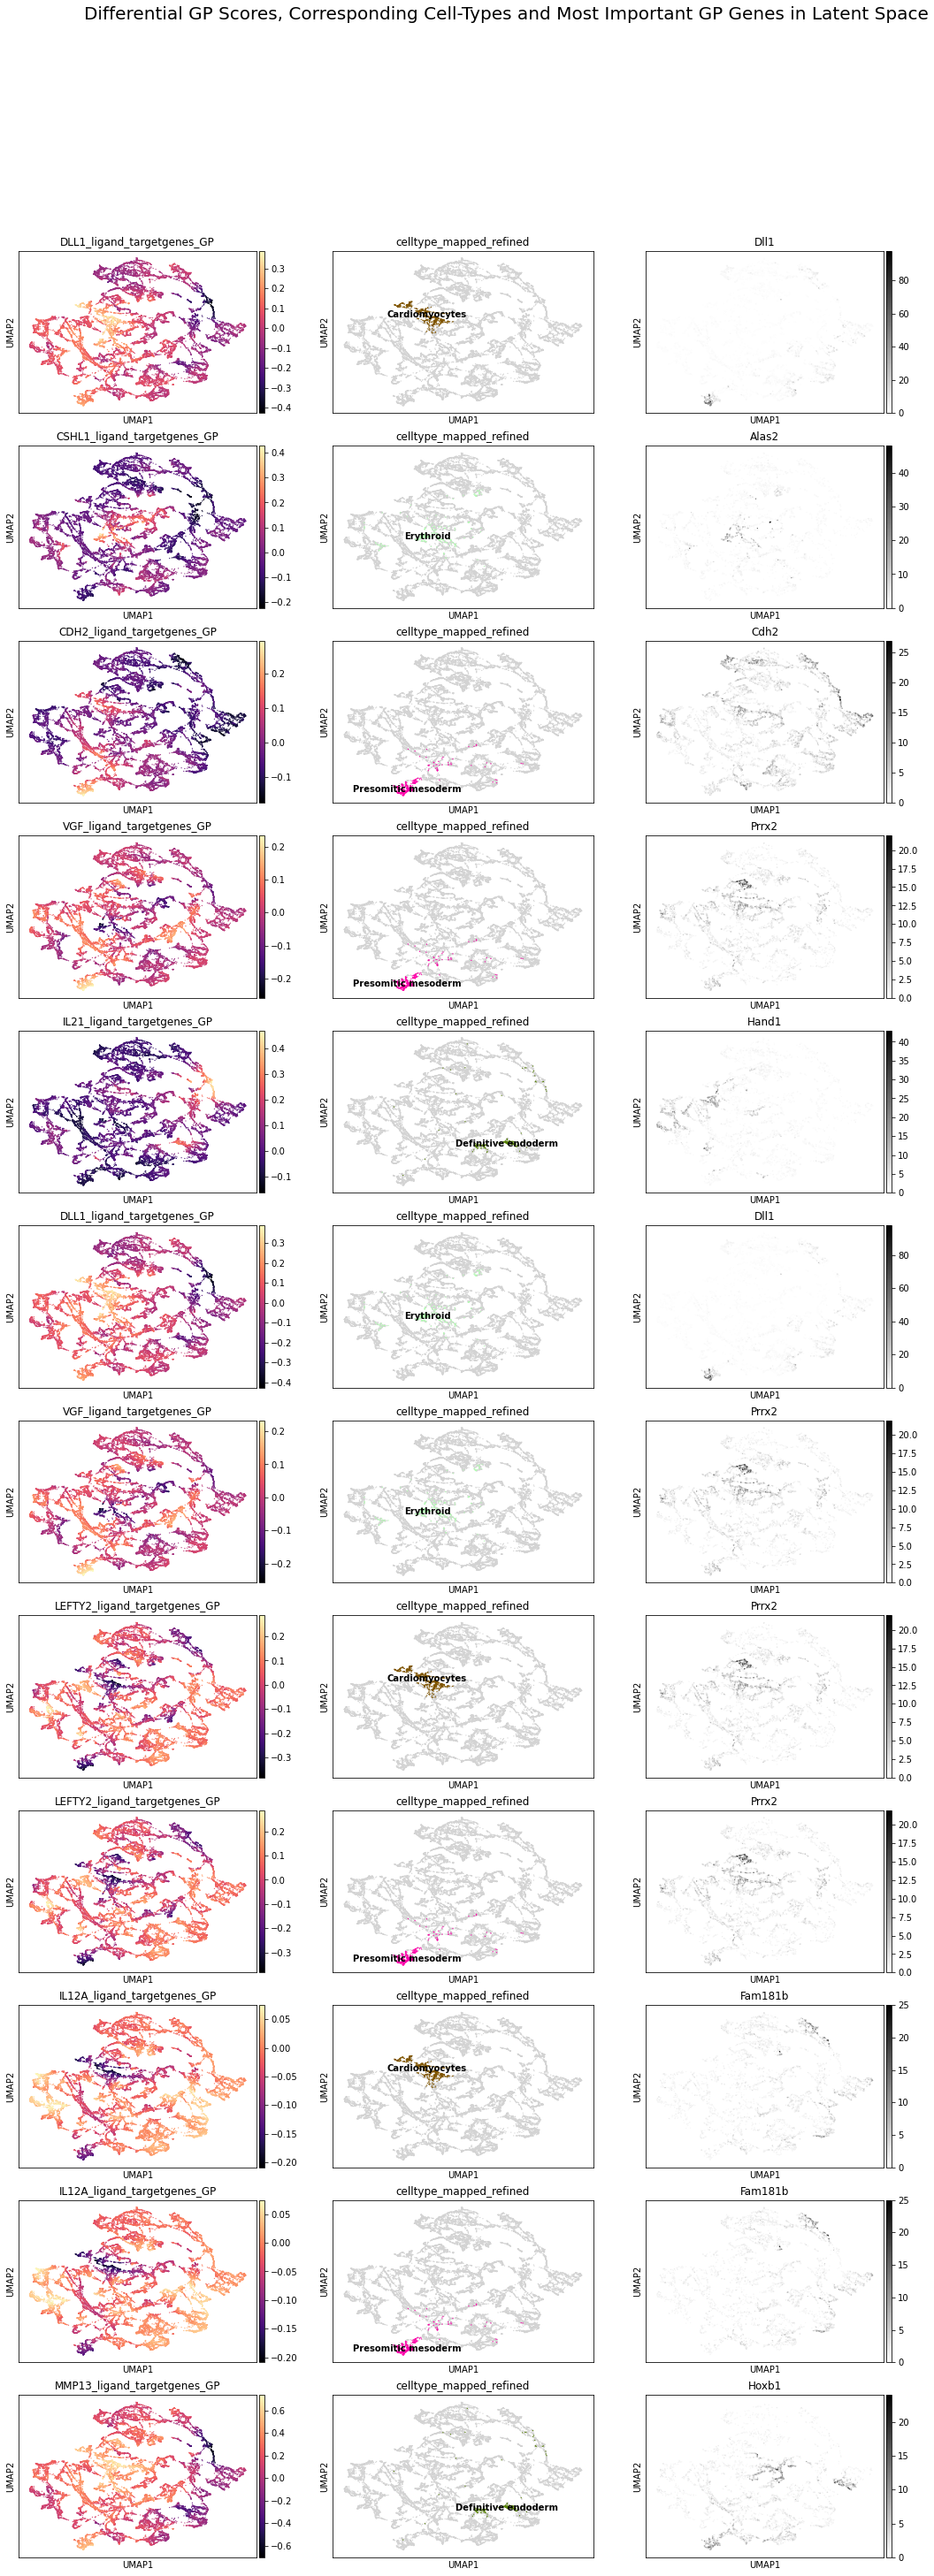

In [67]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/cell_type_gp_scores_cell_types_most_important_genes_{current_timestamp}.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

##### 6.3.1.2 Explore All GPs Across Specific Categories

In [80]:
selected_cats = ["Erythroid", "Endothelium"]

In [81]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=None,
                                                      selected_cats=selected_cats,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

In [82]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

category                  gene_program      p_h0      p_h1  \
0  Erythroid   CSHL1_ligand_targetgenes_GP  0.766180  0.233820   
1  Erythroid    DLL1_ligand_targetgenes_GP  0.736164  0.263836   
2  Erythroid  SECTM1_ligand_targetgenes_GP  0.679079  0.320921   
3  Erythroid   MMP13_ligand_targetgenes_GP  0.654248  0.345752   
4  Erythroid    GDF3_ligand_targetgenes_GP  0.634947  0.365053   
5  Erythroid   GPNMB_ligand_targetgenes_GP  0.617839  0.382161   

   log_bayes_factor  
0          1.186865  
1          1.026124  
2          0.749544  
3          0.637763  
4          0.553498  
5          0.480386

In [83]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

category                 gene_program      p_h0      p_h1  \
51  Erythroid    VGF_ligand_targetgenes_GP  0.229554  0.770446   
50  Erythroid  SFRP2_ligand_targetgenes_GP  0.355894  0.644106   
49  Erythroid    GH2_ligand_targetgenes_GP  0.357000  0.643000   
48  Erythroid   IL10_ligand_targetgenes_GP  0.369220  0.630780   
47  Erythroid   CSH1_ligand_targetgenes_GP  0.370428  0.629572   
46  Erythroid   IL21_ligand_targetgenes_GP  0.391396  0.608604   

    log_bayes_factor  
51         -1.210833  
50         -0.593231  
49         -0.588411  
48         -0.535563  
47         -0.530380  
46         -0.441448

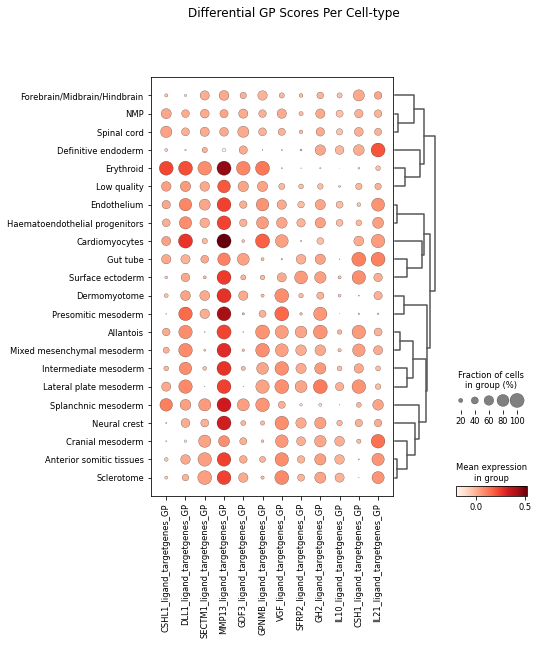

In [84]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/differential_gp_scores_per_cell_type_specific_categories_{current_timestamp}.png")
plt.show()

In [85]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

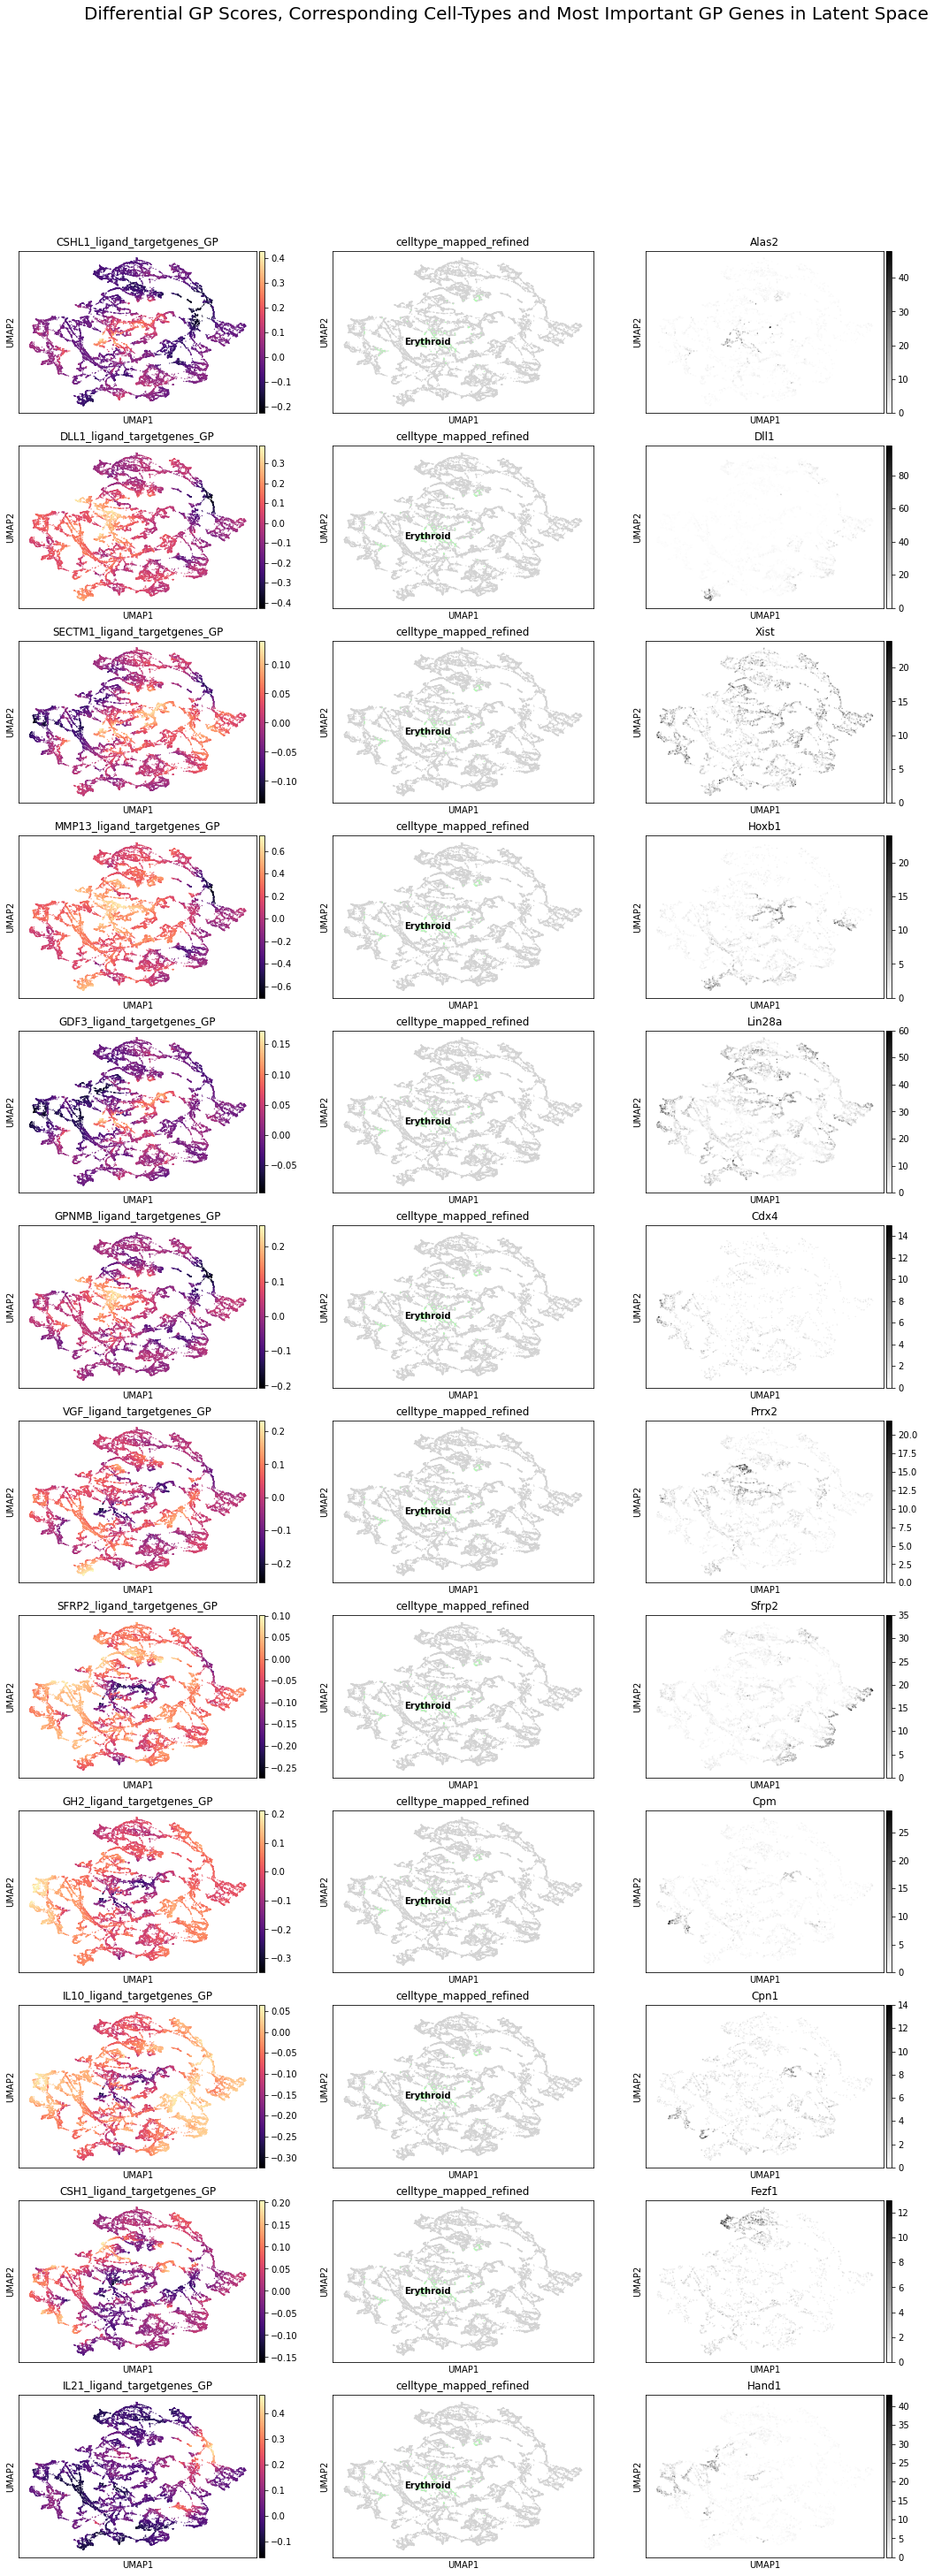

In [86]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/cell_type_gp_scores_cell_types_most_important_genes_{current_timestamp}.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

##### 6.3.1.3 Explore Specific GPs

In [88]:
selected_gps = ["BMP7_ligand_receptor_GP", "EPOR_ligand_receptor_GP"]

In [96]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_unique_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                                      adata=model.adata,
                                                      selected_gps=selected_gps,
                                                      selected_cats=None,
                                                      gp_scores_weight_normalization=False,
                                                      comparison_cats="rest",
                                                      n_sample=1000,
                                                      key_added=differential_gp_scores_key,
                                                      n_top_up_gps_retrieved=n_top_up_gps,
                                                      n_top_down_gps_retrieved=n_top_down_gps,
                                                      seed=random_seed)

GP 'BMP7_ligand_receptor_GP' is not an active gene program. Continuing anyways.
GP 'EPOR_ligand_receptor_GP' is not an active gene program. Continuing anyways.


In [97]:
# Display top upregulated gene programs
top_up_gp_df = model.adata.uns[differential_gp_scores_key][:n_top_up_gps]
display(top_up_gp_df)

category             gene_program      p_h0  \
0                     Endothelium  BMP7_ligand_receptor_GP  0.601441   
1                    Neural crest  BMP7_ligand_receptor_GP  0.589504   
2        Anterior somitic tissues  BMP7_ligand_receptor_GP  0.577159   
3  Haematoendothelial progenitors  BMP7_ligand_receptor_GP  0.566592   
4                Cranial mesoderm  BMP7_ligand_receptor_GP  0.561847   
5                     Spinal cord  EPOR_ligand_receptor_GP  0.558726   

       p_h1  log_bayes_factor  
0  0.398559          0.411473  
1  0.410496          0.361917  
2  0.422841          0.311121  
3  0.433408          0.267960  
4  0.438153          0.248663  
5  0.441274          0.235993

In [98]:
# Display top downregulated gene programs
top_down_gp_df = model.adata.uns[differential_gp_scores_key][-n_top_down_gps:][::-1]
display(top_down_gp_df)

category             gene_program      p_h0      p_h1  \
43       Cardiomyocytes  EPOR_ligand_receptor_GP  0.265314  0.734686   
42  Presomitic mesoderm  EPOR_ligand_receptor_GP  0.304970  0.695030   
41  Presomitic mesoderm  BMP7_ligand_receptor_GP  0.417486  0.582514   
40          Spinal cord  BMP7_ligand_receptor_GP  0.426719  0.573281   
39                  NMP  BMP7_ligand_receptor_GP  0.432244  0.567756   
38  Definitive endoderm  BMP7_ligand_receptor_GP  0.432543  0.567457   

    log_bayes_factor  
43         -1.018528  
42         -0.823744  
41         -0.333104  
40         -0.295249  
39         -0.272703  
38         -0.271482

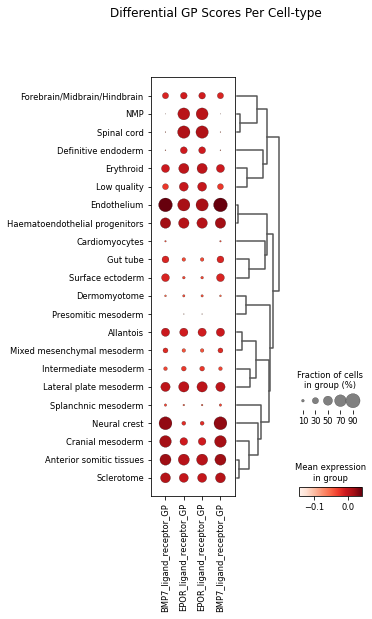

In [99]:
fig = sc.pl.dotplot(model.adata,
                    top_unique_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Differential GP Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/differential_gp_scores_per_cell_type_specific_gps_{current_timestamp}.png")
plt.show()

In [100]:
top_cats = top_up_gp_df["category"].append(top_down_gp_df["category"]).to_list()
top_gps = top_up_gp_df["gene_program"].append(top_down_gp_df["gene_program"]).to_list()
top_genes = []

for gp in top_gps:
    top_genes.append(
        model.compute_gp_gene_importances(selected_gp=gp)["gene"][0])

GP 'BMP7_ligand_receptor_GP' is not an active gene program. Continuing anyways.
GP 'BMP7_ligand_receptor_GP' is not an active gene program. Continuing anyways.
GP 'BMP7_ligand_receptor_GP' is not an active gene program. Continuing anyways.
GP 'BMP7_ligand_receptor_GP' is not an active gene program. Continuing anyways.
GP 'BMP7_ligand_receptor_GP' is not an active gene program. Continuing anyways.
GP 'EPOR_ligand_receptor_GP' is not an active gene program. Continuing anyways.
GP 'EPOR_ligand_receptor_GP' is not an active gene program. Continuing anyways.
GP 'EPOR_ligand_receptor_GP' is not an active gene program. Continuing anyways.
GP 'BMP7_ligand_receptor_GP' is not an active gene program. Continuing anyways.
GP 'BMP7_ligand_receptor_GP' is not an active gene program. Continuing anyways.
GP 'BMP7_ligand_receptor_GP' is not an active gene program. Continuing anyways.
GP 'BMP7_ligand_receptor_GP' is not an active gene program. Continuing anyways.


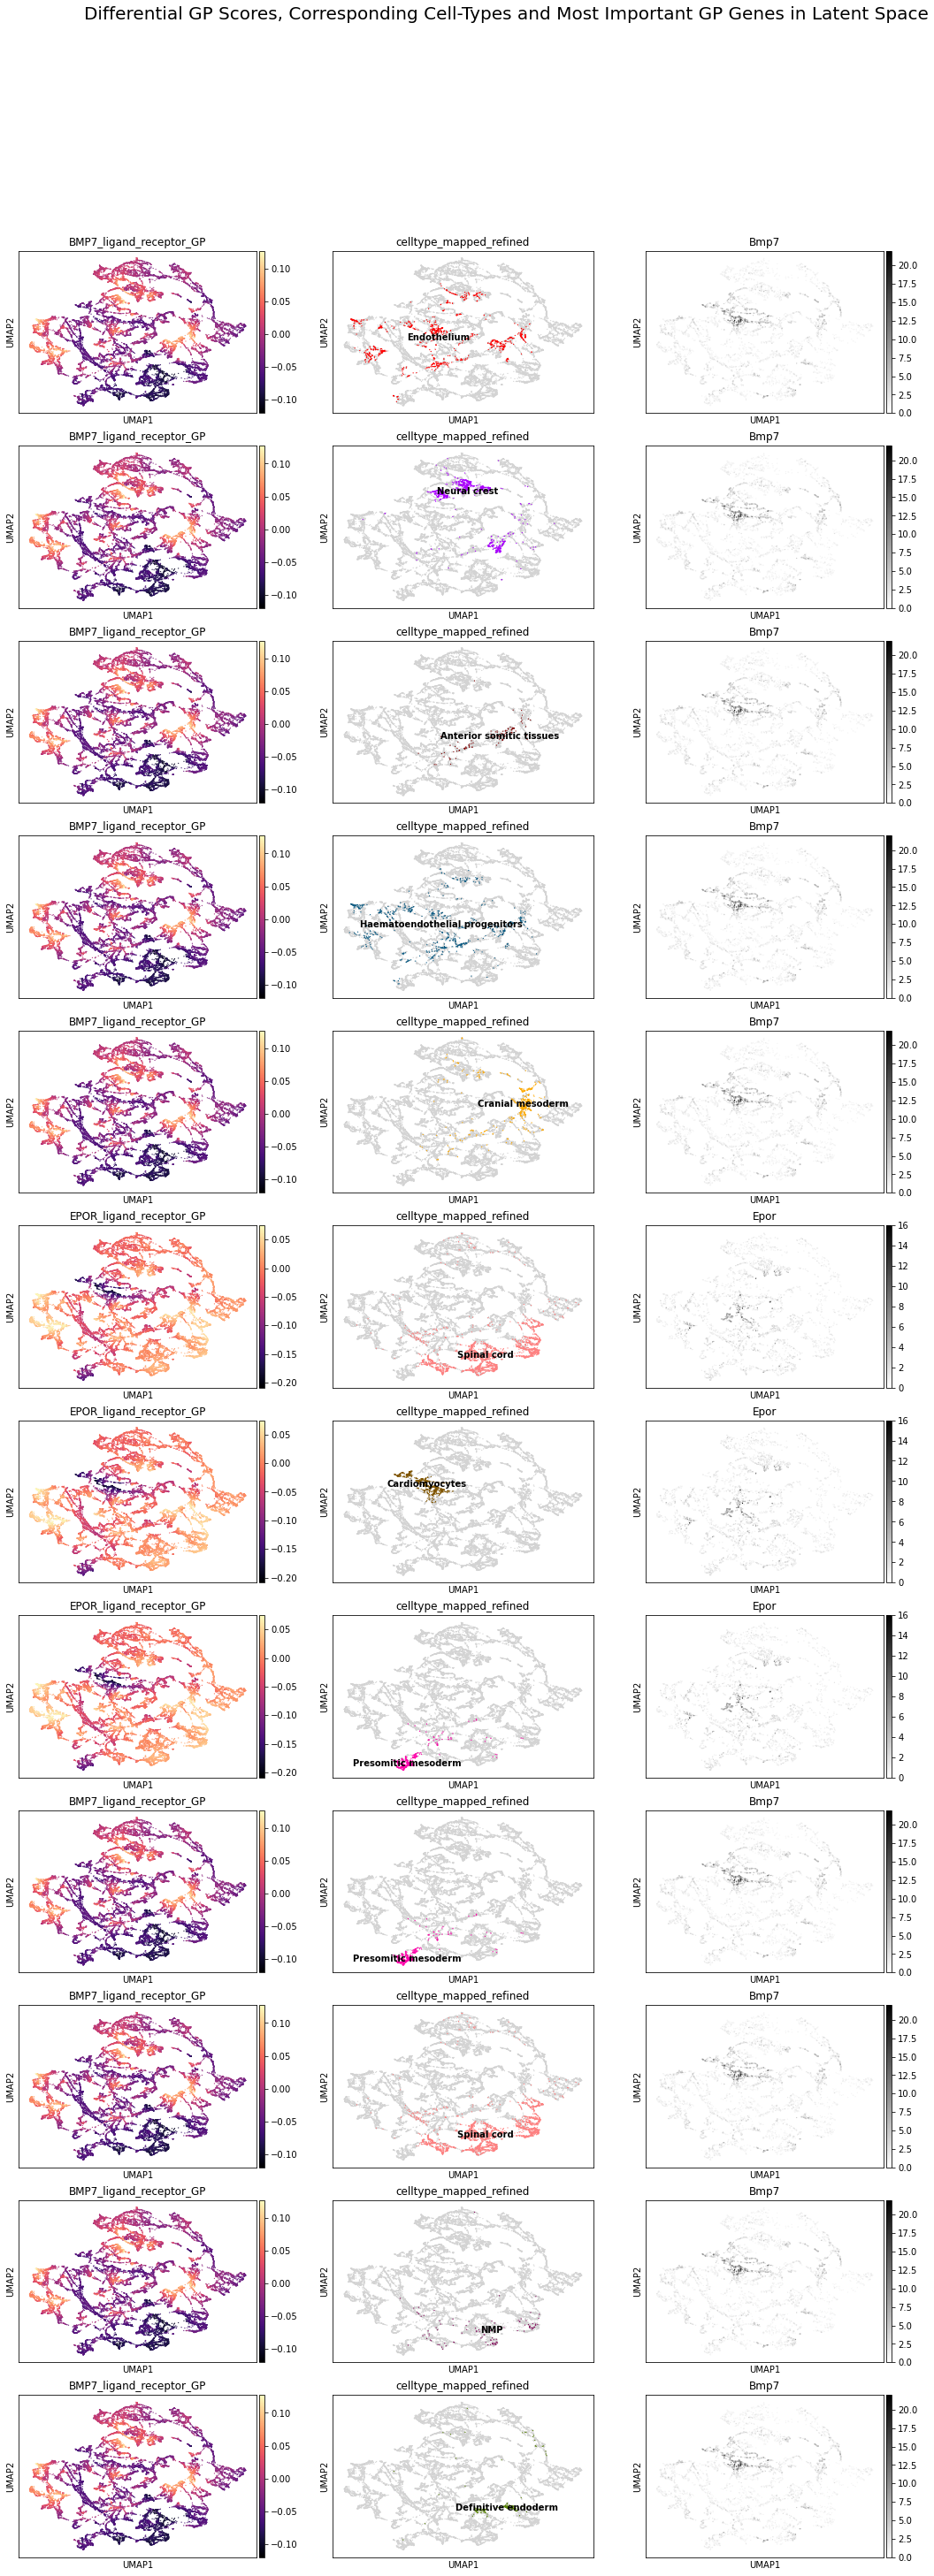

In [101]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18, 4*len(top_gps)))
title = fig.suptitle(t="Differential GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space",
                     x=0.55,
                     y=0.96,
                     fontsize=20)
for i in range(len(top_gps)):
    sc.pl.umap(model.adata, color=top_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(model.adata,
               color=[cell_type_key],
               color_map="magma",
               groups=top_cats[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(model.adata,
               color=top_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/cell_type_gp_scores_cell_types_most_important_genes_{current_timestamp}.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

#### 6.3.2 Spatial Gene Program Enrichment Scores

#### 6.3.3 Gene Program Gene Importances

In [102]:
selected_gp = ["BMP7_ligand_receptor_GP"]

In [103]:
gene_importances_df = model.compute_gp_gene_importances(
    selected_gp="BMP7_ligand_receptor_GP",
    adata=None)

display(gene_importances_df)

GP 'BMP7_ligand_receptor_GP' is not an active gene program. Continuing anyways.


gene gene_entity  gene_weight_sign_corrected  gene_importance
0   Bmp7      source                    0.002147         0.683524
1  Acvr1      target                    0.000994         0.316476

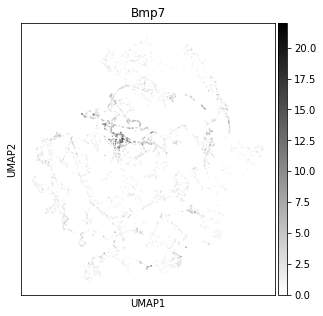

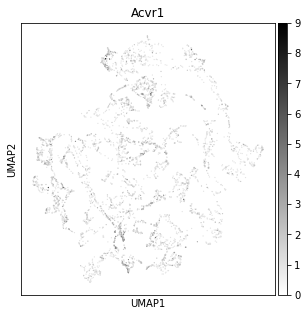

In [104]:
genes = list(gene_importances_df["gene"])

for gene in genes:
    sc.pl.umap(model.adata,
               color=gene,
               color_map="binary",
               legend_loc="on data",
               na_in_legend=False)